<a href="https://colab.research.google.com/github/RMilock/ComplexSpread/blob/main/Simple_SIR_ver15_3(19%3A17).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Function definitions

In [94]:
def sir(G, beta = 1e-3, mu = 0.05, k = 10):
    'Number of nodes in the graph'
    N = G.number_of_nodes()
    
    'Label the individual wrt to the # of the node'
    node_labels = G.nodes()
    
    'Currently infected individuals and the future infected and recovered' 
    inf_list = [] 
    cum_total_inf = []
    prevalence = []
    recovered = []

    'Initial Conditions'
    current_state = ['S' for i in node_labels] 
    future_state = ['S' for i in node_labels]
    
    random.seed(0)

    'Selects the seed of the disease'
    seeds = random.sample(range(N), k) 
    for seed in seeds:
      current_state[seed] = 'I'
      future_state[seed] = 'I'
      inf_list.append(seed)


    'initilize prevalence and revocered list'
    prevalence = [len(inf_list)/N]
    recovered = [0]
    cum_positives = [k/N]


    loop = 0
    'start and continue whenever there s 1 infected'
    while(len(inf_list)>0):        
        
        daily_new_inf = 0
        'Infection Phase: each infected tries to infect all of the neighbors'
        for i in inf_list:
            'Select the neighbors of the infected node'
            tests = G.neighbors(i) #only != wrt to the SIS: contact are taken from G.neighbors            
            for j in tests:
                'If the contact is susceptible and not infected by another node in the future_state, try to infect it'
                if current_state[j] == 'S' and future_state[j] == 'S':
                    if random.random() < beta:
                        future_state[j] = 'I'; daily_new_inf += 1
                    else:
                        future_state[j] = 'S'
        
        cum_positives.append(cum_positives[-1]+daily_new_inf/N)  
        #loop +=1;
        #print("loop:", loop, cum_total_inf, cum_total_inf[-1], daily_new_inf/N)

        'Recovery Phase: each infected in the current state recovers with probability mu'        
        for i in inf_list:
            if random.random() < mu:
                future_state[i] = 'R'
            else:
                future_state[i] = 'I'
        
        'Time update: once infections and recovery ended, we move to the next time-step'
        'The future state becomes the current one'
        current_state = future_state.copy() #w/o .copy() it's a mofiable-"view"
       
        'Updates inf_list with the currently fraction of inf/rec' 
        inf_list = [i for i, x in enumerate(current_state) if x == 'I']
        rec_list = [i for i, x in enumerate(current_state) if x == 'R']

        
        'Saves the fraction of infected and recovered in the current time-step'

        prevalence.append(len(inf_list)/float(N))
        recovered.append(len(rec_list)/float(N))
 
    return prevalence, recovered, cum_positives

def plot_sir(G, beta = 1e-3, mu = 0.05, k = 10):
  # MF_SIR: beta = 1e-3, MF_SIR: mu = 0.05
  N = G.number_of_nodes()
  'plot ratio of daily infected and daily cumulative recovered'
  prevalence, recovered, cum_positives = sir(G, beta, mu, k)
  plt.plot(prevalence, label="Infected/N")
  plt.plot(recovered, label="Recovered/N")
  plt.plot(cum_positives, label="CD_Inf /N")


  'plot horizontal line to highlight the initial infected'
  plt.axhline(k/N, color = "r", ls="dashed", label = "Starting_Inf /N")
  locs, labels = plt.yticks()
  locs_yticks = np.array([])
  for i in range(len(locs)): 
      if locs[i] <= k/N < locs[i+1]:  
          locs_yticks  = np.concatenate((locs[1:i+1], [k/N], locs[i+1:-1])) #omit the 1st and last for better visualisation
  plt.yticks(locs_yticks, np.round(locs_yticks,3))


  'plot labels'
  plt.xlabel('Time', fontsize = 16)
  plt.ylabel('Indivs/N', fontsize = 16)
  plt.legend(loc="best");

'Net Infos'
def infos_sorted_nodes(G, num_nodes = False):
    'sort nodes by key = degree. printing order: node, adjacent nodes, degree'
    print("Triplets of (nodes, edges, degree) sorted by degree: \n")
    nodes = G.nodes()
    print("Sum_i k_i: ", np.sum([j for (i,j) in G.degree() ]), \
          " <k>: ", np.sum([j for (i,j) in G.degree() ]) / len(nodes), 
          " and <k>/N ", np.sum([j for (i,j) in G.degree() ]) / len(nodes)**2, end="\n\n" )
    
    'put adj_matrix into dic from better visualisation'
    adj_matrix =  nx.adjacency_matrix(G).todense()
    adj_dict = {i: np.nonzero(row)[1].tolist() for i,row in enumerate(adj_matrix)}

    infos = zip([x for x in nodes], [adj_dict[i] for i in range(len(nodes))], [G.degree(x) for x in nodes])
    inner_sorted_nodes = sorted( infos, key = lambda x: x[2])
    
    if num_nodes == True:  num_nodes = len(nodes)
    if num_nodes == False: num_nodes = 0
    for i in range(num_nodes):
      print( inner_sorted_nodes[i] )

def plot_G_degdist_adjmat_sir(G, figsize = (12,12), beta = 1e-3, mu = 0.05, k = 10, log = False):
  
  def rhp(n, decimals=0): #round_half_up
    import math
    multiplier = 10 ** decimals
    return int(math.floor(n*multiplier + 0.5) / multiplier)

  fig, axs = plt.subplots(2,2, figsize = figsize)
  nx.draw_circular(G, ax=axs[0,0], with_labels=True, font_size=12, node_size=5, width=.3)
  
  'set xticks to be centered'
  sorted_degree = np.sort([G.degree(n) for n in G.nodes()])

  'degree distribution + possonian distr'
  from scipy.stats import poisson
  bins = np.arange(sorted_degree[0]-1,sorted_degree[-1]+2)
  x = bins
  mean = np.sum([j for (i,j) in G.degree() ]) / G.number_of_nodes() 
  y = poisson.pmf(x, mean)
  n, hist_bins, patches = axs[0,1].hist(sorted_degree, bins = bins, \
                                        log = log, density=0, color="green", ec="black", lw=1, align="left", label = "degrees distr")
  hist_mean = n[np.where(hist_bins == rhp(mean))]; pois_mean = poisson.pmf(rhp(mean), mean)
  print( "x = bins", bins, "\nhist_bins", hist_bins, "\ny", y, "\nn", n, \
        "\npois mean", pois_mean , "hist_mean", hist_mean,  \
        "\nmean", mean, "\nhist_mean", hist_mean, "  poisson.pmf", poisson.pmf(int(mean),mean), )
  axs[0,1].plot(bins, y * hist_mean / pois_mean, "bo--", lw = 2, label = "poissonian distr")
  axs[0,1].set_xlim(bins[0],bins[-1]) 
  axs[0,1].legend(loc = "best")
  

  'plot adjiacency matrix'
  adj_matrix = nx.adjacency_matrix(G).todense()
  axs[1,0].matshow(adj_matrix, cmap=plt.cm.Greens)
  print("Adj_matrix is symmetric", np.allclose(adj_matrix, adj_matrix.T))

  'plot sir'
  plot_sir(G, beta, mu, k)

## Importation

In [95]:
import random
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product

np.set_printoptions(precision=4, suppress=True)

#make the axes white
params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k",
        "axes.titlecolor":"k"}
plt.rcParams.update(params)

## Create a Fully Connected Network

x = bins [ 998  999 1000] 
hist_bins [ 998  999 1000] 
y [0.0126 0.0126 0.0126] 
n [   0. 1000.] 
pois mean 0.012620922336039673 hist_mean [1000.] 
mean 999.0 
hist_mean [1000.]   poisson.pmf 0.012620922336039673
Adj_matrix is symmetric True
Triplets of (nodes, edges, degree) sorted by degree: 

Sum_i k_i:  999000  <k>:  999.0  and <k>/N  0.999



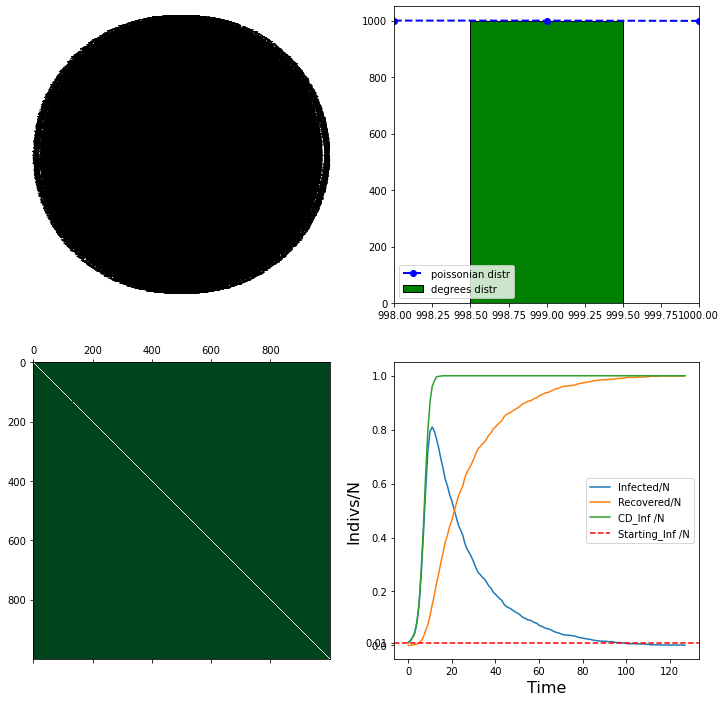

In [96]:

N = int(1e3); cut_off = 0; k = 10
G = nx.Graph(); 
beta_def = 1e-3 # infection probability. MF_SIR: beta = 1e-3
mu_def = 0.05 # recovery probability. MF_SIR: mu = 0.05
beta = beta_def

edges = set()
'Add nodes to form a fully connected network'
for i,j in product(range(N), repeat=2):
  if i != j%N: # since i,j "run freely", we have 2p of chance of edging. So, the mean=n*2p
    edges.add((i,j))

G.add_edges_from(edges)
plot_G_degdist_adjmat_sir(G)
infos_sorted_nodes(G)

plot_name = "Fully_Connected_Network"+ ".pdf"; plt.savefig(plot_name)
plt.show()

## Start Pruning the Net

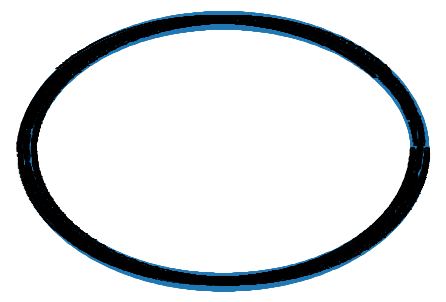

In [73]:
'''
Independetly on the rewiring of the graph, I need to remove the "most far" nodes.
- since my work would be based on a circular layout, I find the "most far" by using hops to reach a node in the cycle_graph;
- number_left_links is found by "round_down" the approximation;
- not to connect clock-wise via the same previous link, use "list_cicled" to connect "forward. 
Other way around, use L = nodes and N = 8; but adj.matrix changes.
'''
def circ_diam(G): 
    n = nx.number_of_nodes(G)
    if n % 2 == 0: return int(n/2)
    elif n % 2 == 1: return int( (n-1)/2 )

def cy_dist(i,j): return nx.shortest_path_length(nx.cycle_graph(N), source = i, target = j)

'In principle, we could have integer or half int. So, approximate down the number of left links, i.e. nl_links. '
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

def nl_links(N, nr):
    rounded = round_down(N-1 - nr_links)
    if rounded % 2 == 1: return rounded -1
    return rounded

'cycle a list from start to the end = len'
def list_cicled(L, start = None, length = None):
    from itertools import cycle, islice, dropwhile
    if length == None: length = len(L)
    if start == None: start = L[0]
    
    cycled = cycle(L)  # indefinetely-cycle thorugh the list 'L'
    skipped = dropwhile(lambda x: x != start, cycled)  # drop the values until x == start
    sliced = islice(skipped, None, length)  # islice('ABCDEFG', start = 0, stop = None, step = 2) --> A C E G
    return list(sliced)

'G.clear all nodes and edges and start rewiring'
G.clear()
G = nx.cycle_graph(N, create_using=None)
#plot_G_degdist_adjmat_sir(G)
nx.draw_circular(G, with_labels = True)

Total Links: 999; nr_links: 499.5; nl_links (if N is even--round_down): 499.0
x = bins [499 500 501] 
hist_bins [499 500 501] 
y [0.0178 0.0178 0.0178] 
n [   0. 1000.] 
pois mean 0.017838267869512373 hist_mean [1000.] 
mean 500.0 
hist_mean [1000.]   poisson.pmf 0.017838267869512373
Adj_matrix is symmetric True


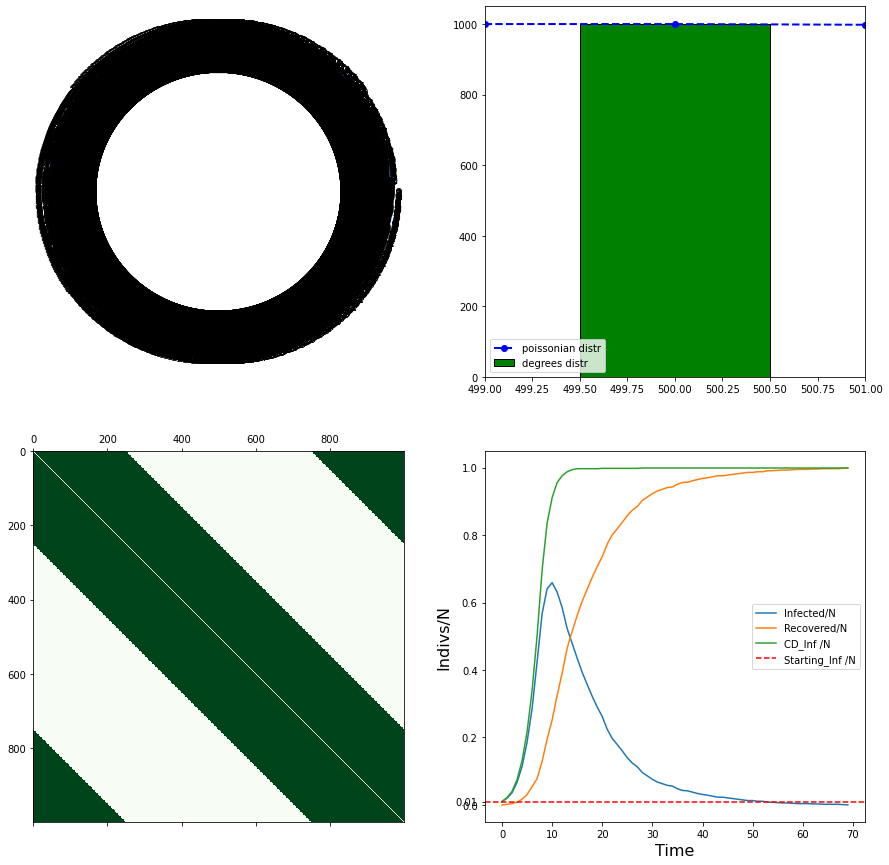

In [74]:
'set number of removed and left nodes. NB: If nl is odd, the effective links are nl_links+1, since the net is periodic'
frac_removed_links = 0.5
nr_links = (N-1) * frac_removed_links; nl_links = round_down(N-1 - nr_links)
beta, mu = beta_def/frac_removed_links, mu_def/frac_removed_links

nodes = [x for x in G.nodes()]
print("Total Links: {0}; nr_links: {1}; nl_links (if N is even--round_down): {2}".format(len(nodes)-1, nr_links, nl_links))

'impose nl_links via NNAR (nearest neighbors anticlock-wise re-wiring)'
def modN(x): return x % N

G.remove_edges_from(G.edges())
edges = set() 
for i in nodes:
  for j in range(1, int(nl_links//2)+1):
    edges.add(( i,modN(i+j) )); edges.add( (i,modN(i-j)) )
    if nl_links % 2 == 1.0: edges.add( (i,modN(i+j+1)) );
G.add_edges_from(edges)

'plot G, degree distribution and the adiaciency matrix'
plot_G_degdist_adjmat_sir(G, figsize=(15,15), beta = beta, mu = mu)  
plt.show()

## Instead of rewiring, try CONNECTED_Watts-Strogatz Net!

This model works that if k = odd. So, k-1 neighbors are connected + I've choosen that if k_ws = float -> round_half_up(k_ws) = k_ws and let the watts-strogatz model go ahead. Should I go for round_down since "k-1" chioce of "odd-be" numb of neighbors?

Approssima al numero pari "più basso" perché WS_model diminuisce il grado se dispari e rete e sir sarebbero riscalati diversamente.

In [75]:
### DEFINITIONS CELL
def remove_loops_parallel_edges(G, remove_loops = True):
  full_ls = list((G.edges()))
  lpe = []
  for i in full_ls:
    full_ls.remove(i)
    for j in full_ls:
      if i == j: lpe.append(j); #print("i", i, "index", full_ls.index(i)+1, "j", j)
  if remove_loops == True:  
    for x in list(nx.selfloop_edges(G)): lpe.append(x)
    print("Parallel edges and loops removed!")
  return G.remove_edges_from(lpe)

def check_loops_parallel_edges(G):
  ls = list(G.edges())
  print("parallel edges", [i for i in ls for j in ls[ls.index(i)+1:] if i==j])
  print("loops", [(i,j) for (i,j) in set(G.edges()) if i == j])

In [97]:
'rewire all the edges with a probability of p'
def ws_sir(N = int(30), k_ws = None, p = 0.1, infos = True):  
  'in this def: cut_factor = % of links remaining from the full net'
  plt.close();
  if k_ws == None: k_ws = N
  cut_factor = k_ws / N
  'With p = 1 and <k>/N ~ 0, degree distr is sim to a Poissonian'
  G = nx.connected_watts_strogatz_graph( n = N, k = rhp(k_ws), p = p, seed = 1) #k is the number of near linked nodes

  check_loops_parallel_edges(G)
  print("Total edges", len(G.edges()))
  if infos == True: infos_sorted_nodes(G, num_nodes = False)
  'plot G, degree distribution and the adiaciency matrix'
  beta_eff = 0.001/cut_factor; mu_eff = 0.16/cut_factor 
  #Thurner pmts: beta_eff = 0.1, mu = 0.16; k_ws = 3 vel 8
  #MF def: beta, mu = 0.001, 0.05
  plot_G_degdist_adjmat_sir(G, figsize=(15,15), beta = beta_eff, mu = mu_eff, log = True)    
  plt.show()

ws_sir(p = 0.3)

NameError: ignored

## Configurational Model with poissonian degree: 
Question: using this meth, loops and parallel edges are present leading to a adj_matrix not normalized to 1. Since neighbors are involved in sir and contagious is made by (fut = S, curr = S) - nodes, I may leave them, but there're not so in line of "social contacts". So, I prefer to remove them.

TODO: implement the idea of a pruning factor as in ws_sir

Degree sum: 94 with seed: 123

Network Created but w/o standard neighbors wiring!
parallel edges [(13, 22), (13, 22)]
loops []
Parallel edges and loops removed!
parallel edges []
loops []
Triplets of (nodes, edges, degree) sorted by degree: 

Sum_i k_i:  92  <k>:  3.066666666666667  and <k>/N  0.10222222222222223

x = bins [0 1 2 3 4 5 6 7] 
hist_bins [0 1 2 3 4 5 6 7] 
y [0.0466 0.1428 0.219  0.2239 0.1716 0.1053 0.0538 0.0236] 
n [ 0.  2. 10.  9.  4.  3.  2.] 
pois mean 0.22387832879239078 hist_mean [9.] 
mean 3.066666666666667 
hist_mean [9.]   poisson.pmf 0.22387832879239078
Adj_matrix is symmetric True


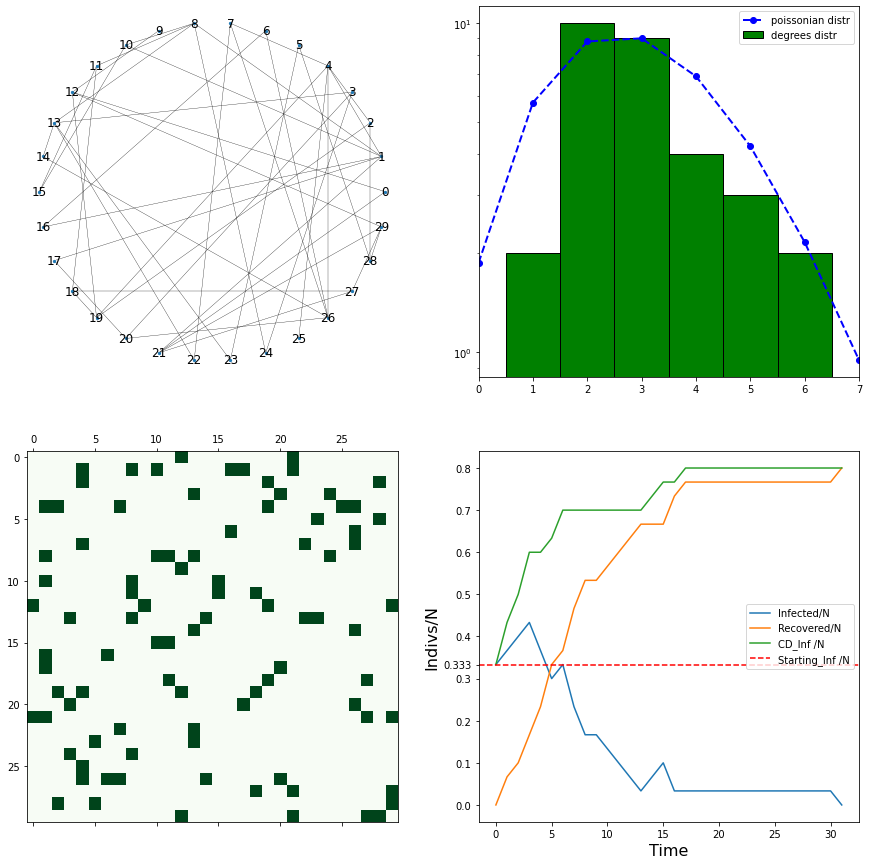

In [81]:
D = 3; seed=123; p = 0; N = int(30)

'''create a network with the node degrees drawn from a poissonian with even sum of degrees'''
np.random.seed(seed)
degrees = np.random.poisson(D,N) #for def of poissonian distr degrees are integers

print("Degree sum:", np.sum(degrees), "with seed:", seed)
while(np.sum(degrees)%2 != 0): #i.e. sum is odd --> change seed
  seed+=1
  np.random.seed(seed)
  degrees = np.random.poisson(D,N)
  print("Degree sum:", np.sum(degrees), "with seed:", seed, )

print("\nNetwork Created but w/o standard neighbors wiring!")
'''create and remove loops since they apppears as neighbors of a node. Check it via print(list(G.neighbors(18))'''
G = nx.configuration_model(degrees, seed = seed)
check_loops_parallel_edges(G)
remove_loops_parallel_edges(G)
check_loops_parallel_edges(G)

infos_sorted_nodes(G)

'plot G, degree distribution and the adiaciency matrix'
cut_factor = 1
beta = 0.1/cut_factor; mu = 0.16/cut_factor
plot_G_degdist_adjmat_sir(G, figsize=(15,15), beta = beta, mu = mu, log = True)    

plt.show()

